In [3]:
import jupyter

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils.system import boot
from src.defaults import TOP2_STOCK_BY_SECTOR, RANDOM_SEEDS
from src.data.feature_pipeline import load_base_dataframe

DEVICE = boot()
OHLCV_DF = load_base_dataframe()

In [5]:
from hurst import compute_Hc
from pyts.image import RecurrencePlot
import datetime

# PROJECT SETUP ==================================
TICKERS         = ["TSLA"] 
#TICKERS = OHLCV_DF['symbol'].unique()
#TICKERS = TOP2_STOCK_BY_SECTOR 

CHAOS_THRESHOLD = 0.45
WINDOW_SIZE     = 120
ENTROPY_BINS    = 10
N_WEEK_DAYS     = 5
STEP_SIZE       = 20
MAX_LEN         = 64
LOOKBACK_BUFFER = 40
ROLLING_WINDOW  = 5
START_DATE      = "2023-01-01",
END_DATE        = "2025-05-01"#pd.Timestamp.today().replace(day=1)
TRAIN_MONTHS    = 2
TEST_MONTHS     = 1
MIN_WINDOW_DAYS = 20
NUM_EPOCHS      = 1
SEEDS = RANDOM_SEEDS[:5]

""" 
DEVELOPER NOTES:
@todo : onehot encode day_of_week so the Model wont use the data as a sized sequence 
"""
BASIC_FEATURES=[
    "close"	,          # Core price for reward and trend awareness
    "volume",          # Volume for activity level
    "candle_body",     # Price strength (close-open)
    "upper_shadow",    # Wick size = volatility / exhaustion
    "lower_shadow",    # Same as above
    "order_flow",      # Flow = pressure indicator (buy/sell imbalance)
    "price_change",    # Price momentum short term
    "volatility",      # Recent price dispersion
    "momentum",        # Rolling price trend
    "vix_norm",        # Implied market risk normalized
    "market_return_1d",# Market regime alignment
    "day_of_week"      # heard it's important                
]

# That’s 12 columns, enough to:
# * See price movement
# * Detect regime shifts
# * Respond to risk

# Second Round:
# * overnight_price_change → if overnight gaps matter to your strategy
# * trade_count_change → intraday activity shifts
# * sp500_norm → macro regime normalization

DEFAULT_INTERNAL_FEATURES = [
    "position",
    "holding_period",
    "cumulative_reward",
    "pct_time",
    "drawdown",
    "unrealized_pnl",
    "entry_price",
    "time_in_position",
    "prev_action"
]



# Data preparation

In [6]:
# DATA PREPROCESSING ===============================
import numpy as np
import pandas as pd
import ace_tools_open as tools

from typing import List, Tuple
from datetime import timedelta
from scipy.stats import entropy, kurtosis
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from dateutil.relativedelta import relativedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, OneHotEncoder




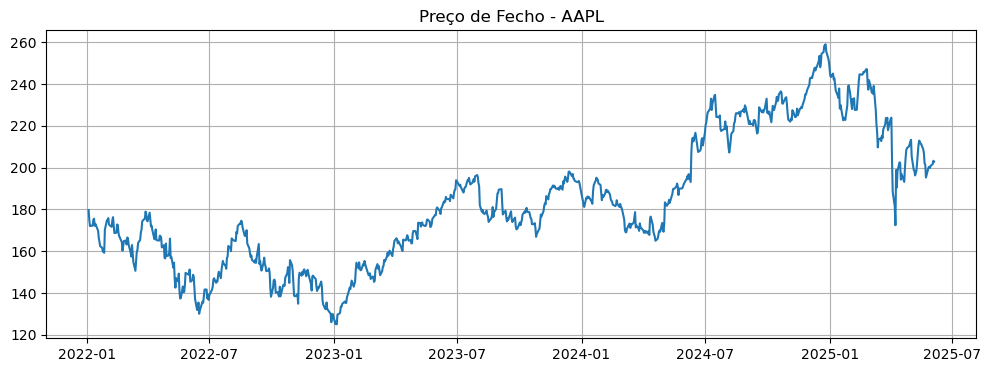

In [84]:
# STEP 1 - GET DATA =======================
# POC

EXPERIENCE_NAME="regime_detection_and_alignment__v2"
TICKERS = ["AAPL"]
df = OHLCV_DF[OHLCV_DF['symbol'].isin(TICKERS)].copy()

# Para POC: Escolher um ticker de destaque
ticker = 'AAPL'  # ou outro em TOP2_STOCK_BY_SECTOR

df = OHLCV_DF[OHLCV_DF['symbol'] == ticker].copy()
df = df.sort_values("date").reset_index(drop=True)

# Visualizar série de preços
plt.figure(figsize=(12, 4))
plt.plot(df["date"], df["close"])
plt.title(f'Preço de Fecho - {ticker}')
plt.grid(True)
plt.show()

In [10]:
def compute_regime_indicators(df, window=30, hurst_window=128):
    df = df.copy()

    df["volatility"] = df["close"].rolling(window).std()
    df["momentum"] = df["close"].pct_change(periods=window)
    df["kurtosis"] = df["close"].rolling(window).apply(lambda x: stats.kurtosis(x), raw=True)
    df["entropy"] = df["close"].rolling(window).apply(
        lambda x: stats.entropy(np.histogram(x, bins=10)[0] + 1), raw=True
    )
    df["adf_pvalue"] = df["close"].rolling(window).apply(
        lambda x: adfuller(x)[1] if len(x.dropna()) == window else np.nan
    )
    
    # Calcular Hurst apenas com janela maior (>=100)
    hurst_vals = []
    for i in range(len(df)):
        if i >= hurst_window:
            window_data = df["close"].iloc[i - hurst_window + 1:i + 1].dropna()
            try:
                hurst_val = compute_Hc(window_data.values, kind="price", simplified=True)[0]
            except:
                hurst_val = np.nan
        else:
            hurst_val = np.nan
        hurst_vals.append(hurst_val)
    
    df["hurst"] = hurst_vals

    # Normalização opcional
    scaler = RobustScaler()
    cols_to_scale = ["volatility", "momentum", "kurtosis", "entropy", "adf_pvalue", "hurst"]
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

    return df

df_ind = compute_regime_indicators(df)
df_ind.dropna(inplace=True)
df_ind

,id,symbol,timestamp,date,open,high,low,close,volume,trade_count,...,vix_norm,sp500,sp500_norm,market_return_1d,volatility,momentum,kurtosis,entropy,adf_pvalue,hurst
128,33552,AAPL,2022-07-11 04:00:00,2022-07-11,145.670,146.64,143.7800,144.87,69704810.0,496269.0,...,0.062094,38.5443,-0.011527,-0.011527,-0.221916,0.218670,-0.600715,1.114093,-0.541368,-0.085462
129,33553,AAPL,2022-07-12 04:00:00,2022-07-12,145.760,148.45,145.0500,145.86,84620032.0,579533.0,...,0.042797,38.1880,-0.009244,-0.009244,-0.206111,0.039087,-0.653589,0.781171,-0.153748,-0.059219
130,33554,AAPL,2022-07-13 04:00:00,2022-07-13,142.990,146.45,142.1201,145.49,77731553.0,559359.0,...,-0.017222,38.0178,-0.004457,-0.004457,-0.263474,-0.420489,-0.578768,0.378024,-0.142357,-0.042852
131,33555,AAPL,2022-07-14 04:00:00,2022-07-14,144.080,148.95,143.2500,148.47,83018114.0,614953.0,...,-0.015660,37.9038,-0.002999,-0.002999,-0.269627,-0.145533,-0.576416,0.378024,0.096372,-0.178093
132,33556,AAPL,2022-07-15 04:00:00,2022-07-15,149.780,150.86,148.2000,150.17,86944893.0,548571.0,...,-0.082197,38.6316,0.019201,0.019201,-0.242951,-0.011541,-0.562733,0.710946,-0.039175,-0.416650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,34276,AAPL,2025-05-29 04:00:00,2025-05-29,203.575,203.81,198.5100,199.95,51477938.0,652509.0,...,-0.006732,59.1217,0.004011,0.004011,-0.036202,-0.236449,-1.203109,1.114093,-1.559136,-0.306657
853,34277,AAPL,2025-05-30 04:00:00,2025-05-30,199.370,201.96,196.7800,200.85,70819942.0,605924.0,...,-0.031804,59.1169,-0.000081,-0.000081,-0.126750,0.250404,-1.160580,0.781171,-1.575147,-0.182465
854,34278,AAPL,2025-06-02 04:00:00,2025-06-02,200.280,202.13,200.1200,201.70,35423294.0,501431.0,...,-0.011309,59.3594,0.004102,0.004102,-0.177557,0.142495,-1.054064,0.781171,-1.489234,0.054384
855,34279,AAPL,2025-06-03 04:00:00,2025-06-03,201.350,203.77,200.9550,203.27,46381567.0,519820.0,...,-0.036492,59.7037,0.005800,0.005800,-0.321928,0.451547,-1.197646,0.781171,-1.477484,0.034453


IndexError: single positional indexer is out-of-bounds

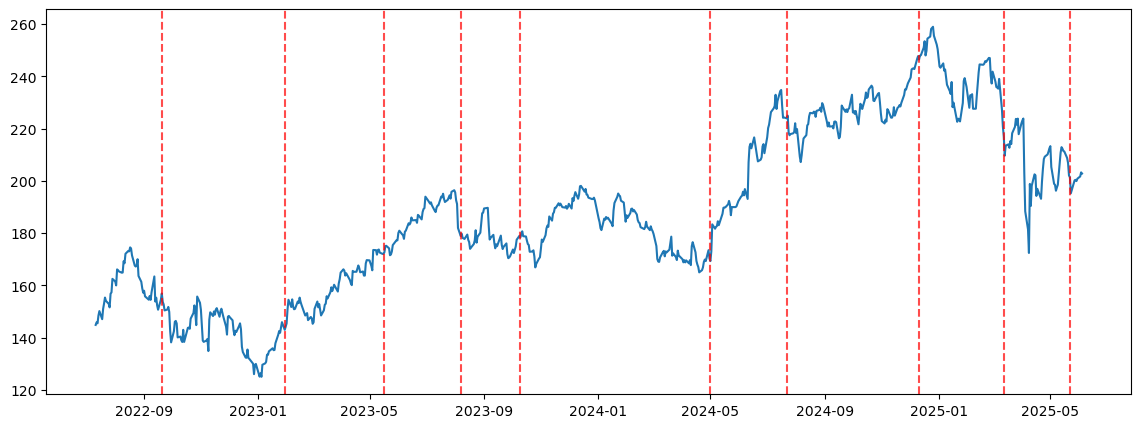

In [13]:
import ruptures as rpt

def detect_change_points(df, features, model="l2", n_bkps=10):
    X = df[features].values
    algo = rpt.Binseg(model=model).fit(X)
    change_points = algo.predict(n_bkps=n_bkps)
    return change_points

features = ["volatility", "momentum", "kurtosis", "entropy", "adf_pvalue", "hurst"]
change_points = detect_change_points(df_ind, features, n_bkps=10)

# Visualizar
plt.figure(figsize=(14, 5))
plt.plot(df_ind["date"], df_ind["close"], label="Close Price")
for cp in change_points:
    plt.axvline(df_ind["date"].iloc[cp], color="red", linestyle="--", alpha=0.7)
plt.title(f"Regime Change Points - {ticker}")
plt.legend()
plt.grid()
plt.show()

In [16]:
from sklearn.cluster import KMeans

def classify_regimes(df, features, n_clusters=4):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    df["regime"] = model.fit_predict(df[features])
    return df

df_regime = classify_regimes(df_ind.copy(), features)
df_regime

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


,id,symbol,timestamp,date,open,high,low,close,volume,trade_count,...,sp500,sp500_norm,market_return_1d,volatility,momentum,kurtosis,entropy,adf_pvalue,hurst,regime
128,33552,AAPL,2022-07-11 04:00:00,2022-07-11,145.670,146.64,143.7800,144.87,69704810.0,496269.0,...,38.5443,-0.011527,-0.011527,-0.221916,0.218670,-0.600715,1.114093,-0.541368,-0.085462,1
129,33553,AAPL,2022-07-12 04:00:00,2022-07-12,145.760,148.45,145.0500,145.86,84620032.0,579533.0,...,38.1880,-0.009244,-0.009244,-0.206111,0.039087,-0.653589,0.781171,-0.153748,-0.059219,1
130,33554,AAPL,2022-07-13 04:00:00,2022-07-13,142.990,146.45,142.1201,145.49,77731553.0,559359.0,...,38.0178,-0.004457,-0.004457,-0.263474,-0.420489,-0.578768,0.378024,-0.142357,-0.042852,1
131,33555,AAPL,2022-07-14 04:00:00,2022-07-14,144.080,148.95,143.2500,148.47,83018114.0,614953.0,...,37.9038,-0.002999,-0.002999,-0.269627,-0.145533,-0.576416,0.378024,0.096372,-0.178093,1
132,33556,AAPL,2022-07-15 04:00:00,2022-07-15,149.780,150.86,148.2000,150.17,86944893.0,548571.0,...,38.6316,0.019201,0.019201,-0.242951,-0.011541,-0.562733,0.710946,-0.039175,-0.416650,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,34276,AAPL,2025-05-29 04:00:00,2025-05-29,203.575,203.81,198.5100,199.95,51477938.0,652509.0,...,59.1217,0.004011,0.004011,-0.036202,-0.236449,-1.203109,1.114093,-1.559136,-0.306657,1
853,34277,AAPL,2025-05-30 04:00:00,2025-05-30,199.370,201.96,196.7800,200.85,70819942.0,605924.0,...,59.1169,-0.000081,-0.000081,-0.126750,0.250404,-1.160580,0.781171,-1.575147,-0.182465,1
854,34278,AAPL,2025-06-02 04:00:00,2025-06-02,200.280,202.13,200.1200,201.70,35423294.0,501431.0,...,59.3594,0.004102,0.004102,-0.177557,0.142495,-1.054064,0.781171,-1.489234,0.054384,1
855,34279,AAPL,2025-06-03 04:00:00,2025-06-03,201.350,203.77,200.9550,203.27,46381567.0,519820.0,...,59.7037,0.005800,0.005800,-0.321928,0.451547,-1.197646,0.781171,-1.477484,0.034453,1


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length

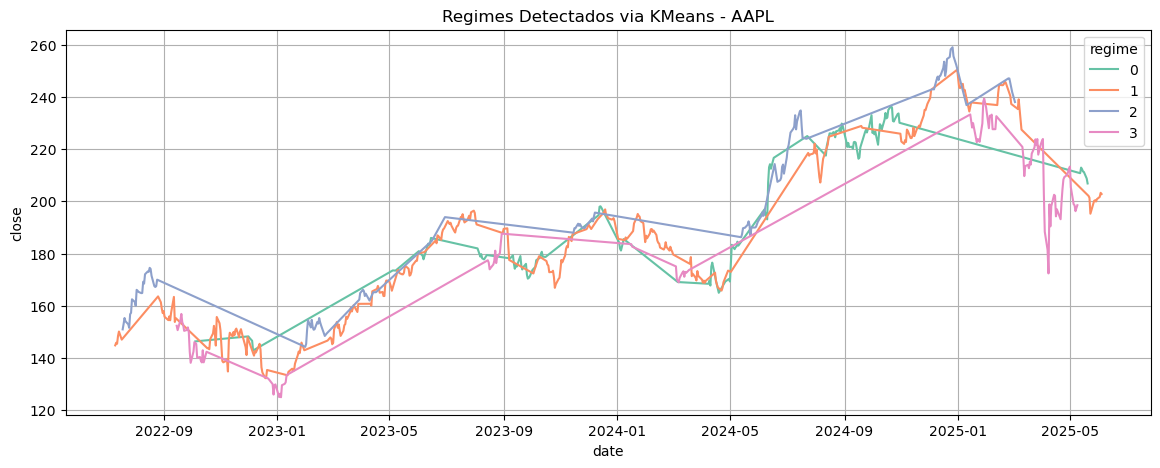

In [18]:
df_regime['regime'].value_counts()
plt.figure(figsize=(14, 5))
palette = sns.color_palette("Set2", df_regime["regime"].nunique())
sns.lineplot(x="date", y="close", hue="regime", data=df_regime, palette=palette)
plt.title(f"Regimes Detectados via KMeans - {ticker}")
plt.grid()
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length

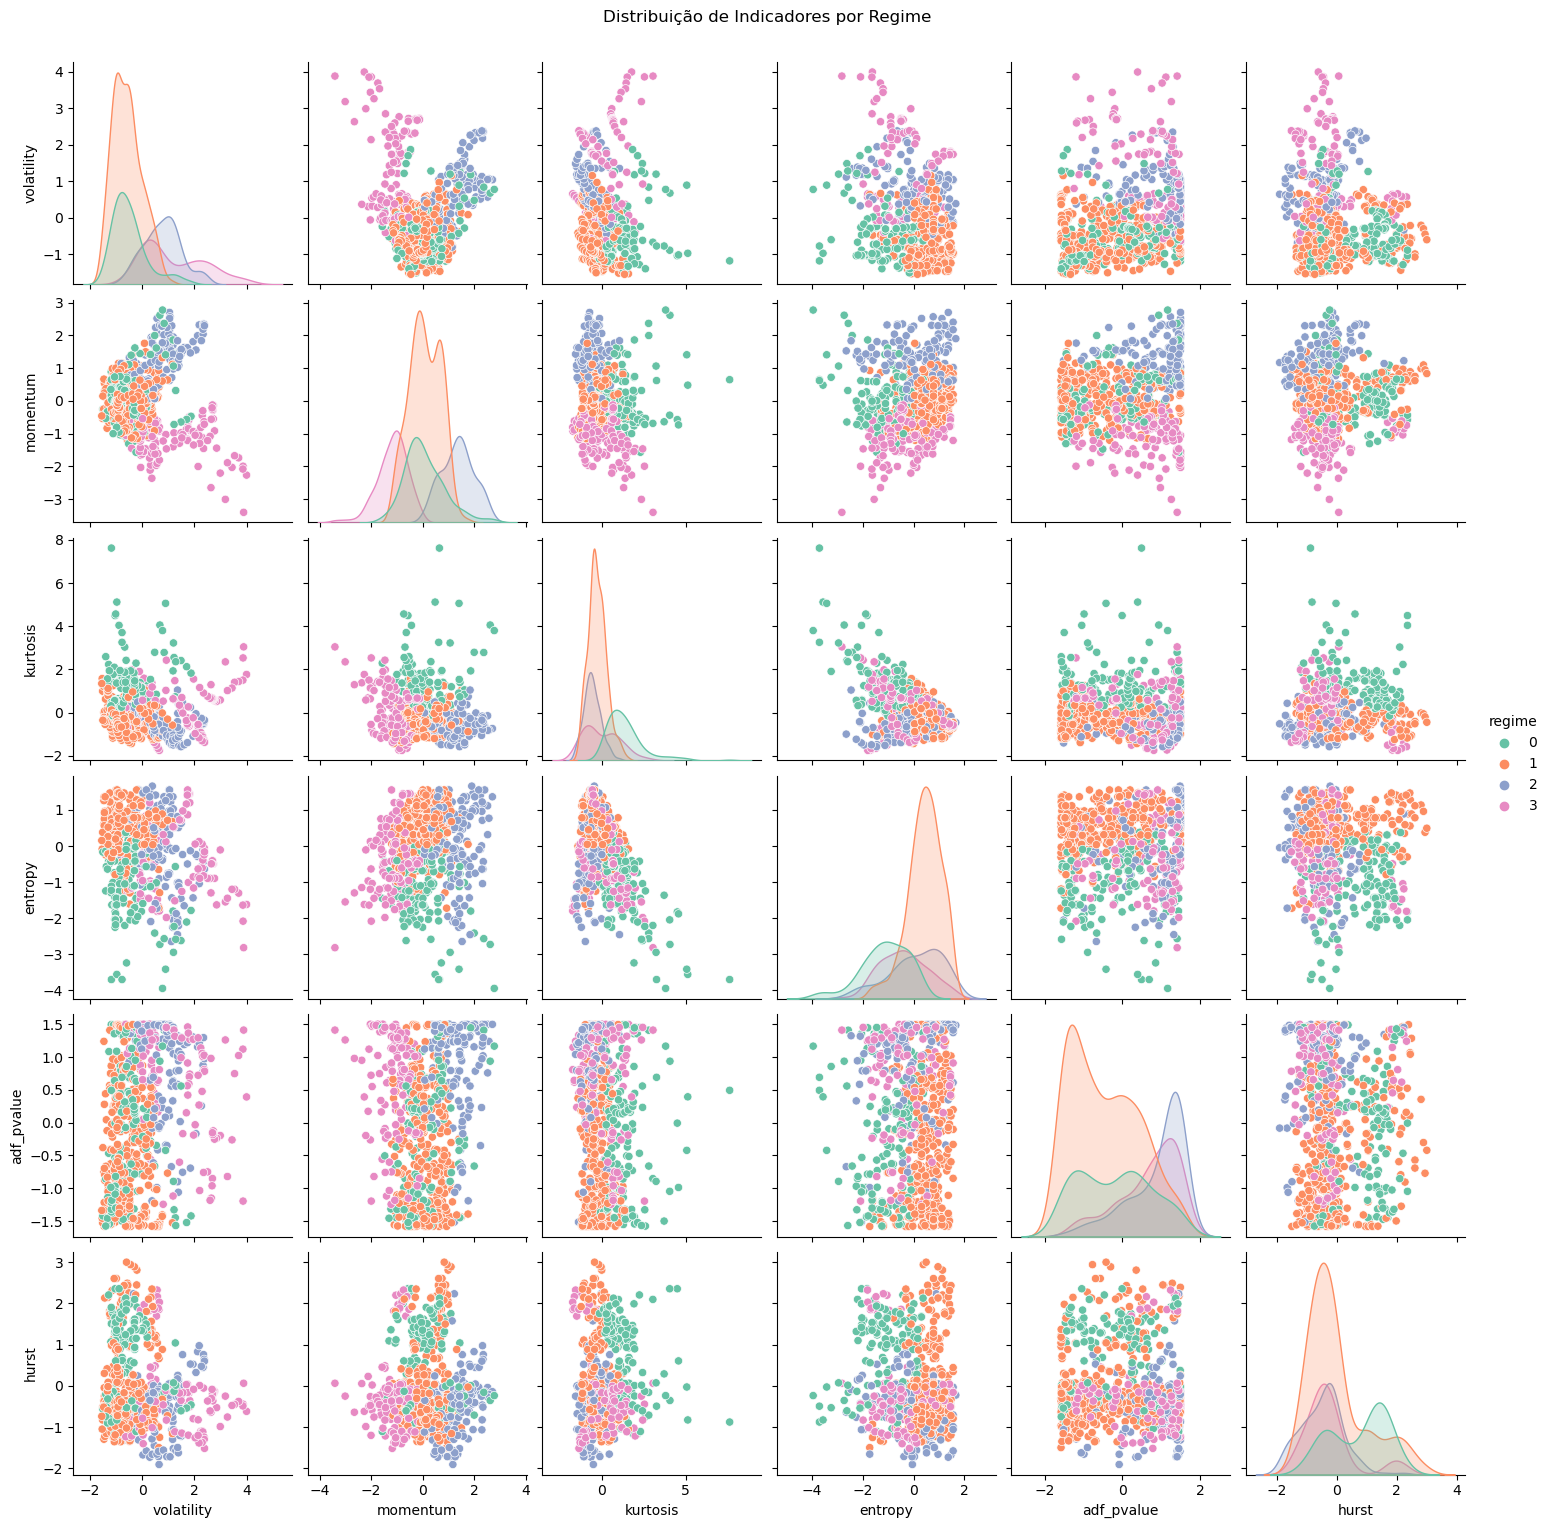

In [19]:
sns.pairplot(df_regime[features + ["regime"]], hue="regime", palette="Set2")
plt.suptitle("Distribuição de Indicadores por Regime", y=1.02)
plt.show()

In [20]:
# Diferença estatística entre regimes: Exemplo com Volatility
import scipy.stats as stats

anova_result = stats.f_oneway(*[
    df_regime[df_regime["regime"] == i]["volatility"].dropna()
    for i in df_regime["regime"].unique()
])

print(f"ANOVA p-value (volatility between regimes): {anova_result.pvalue:.4f}")

ANOVA p-value (volatility between regimes): 0.0000


In [22]:
print(df_regime["regime"].unique())
df_regime["regime"].value_counts()

[1 2 3 0]


regime
1    337
0    139
2    132
3    121
Name: count, dtype: int64

In [27]:
# DIAGONOSTICO DE SEPARABILIDADE COM ANOVA
from scipy.stats import f_oneway

pvals = []
for feat in features:
    groups = [df_regime[df_regime["regime"] == i][feat].dropna() for i in sorted(df_regime["regime"].unique())]
    stat, pval = f_oneway(*groups)
    print(f"{feat:<12} | ANOVA p-value = {pval:.5f}")
    pvals.append(pval)

print('')
anova_separability_success = False
if np.median(pvals)<= 0.05:
    anova_separability_success = True
    print('SUCESSO:\n A classificação dos regimes feita pelo KMeans sobre esses indicadores é estatisticamente justificável. Todos os indicadores têm diferenças significativas entre os regimes detectados — sugerindo que os clusters são não apenas formais, mas economicamente interpretáveis.')
else:
    print('FAIL:\n  A classificação dos regimes feita pelo KMeans sobre esses indicadores é estatisticamente justificável. Todos os indicadores têm diferenças significativas entre os regimes detectados — sugerindo que os clusters são não apenas formais, mas economicamente interpretáveis.')

volatility   | ANOVA p-value = 0.00000
momentum     | ANOVA p-value = 0.00000
kurtosis     | ANOVA p-value = 0.00000
entropy      | ANOVA p-value = 0.00000
adf_pvalue   | ANOVA p-value = 0.00000
hurst        | ANOVA p-value = 0.00000

SUCESSO:
 A classificação dos regimes feita pelo KMeans sobre esses indicadores é estatisticamente justificável. Todos os indicadores têm diferenças significativas entre os regimes detectados — sugerindo que os clusters são não apenas formais, mas economicamente interpretáveis.


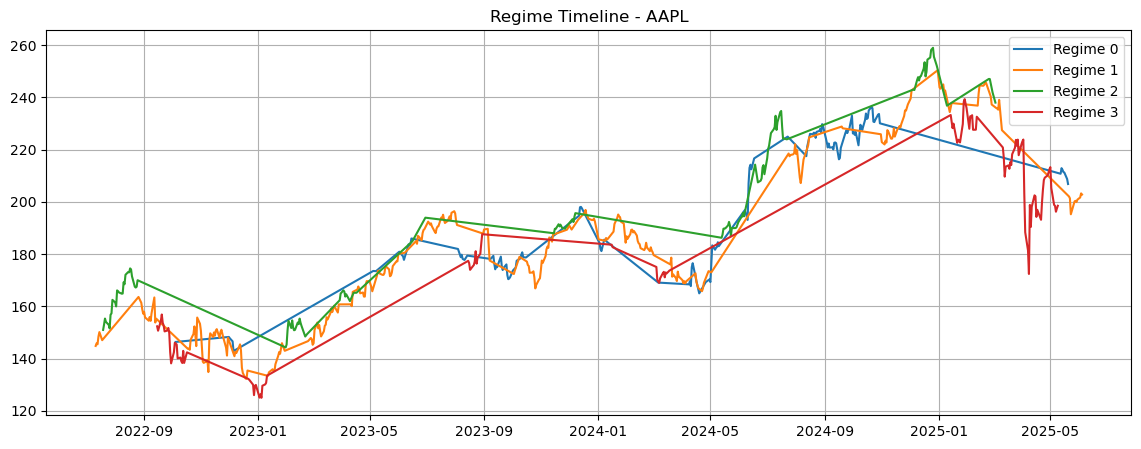

In [28]:
plt.figure(figsize=(14, 5))
palette = sns.color_palette("tab10", n_colors=df_regime["regime"].nunique())
for i, regime_id in enumerate(sorted(df_regime["regime"].unique())):
    subset = df_regime[df_regime["regime"] == regime_id]
    plt.plot(subset["date"], subset["close"], label=f"Regime {regime_id}", color=palette[i])
plt.legend()
plt.title(f"Regime Timeline - {ticker}")
plt.grid(True)
plt.show()

In [63]:
from sklearn.preprocessing import MaxAbsScaler,StandardScaler,RobustScaler,MaxAbsScaler

# ONE LINE TIMEFRAME REGIME SEPARATOR AND VALIDATOR
def regime_classifier(df_ind,
                      features = ["volatility", "momentum", "kurtosis", "entropy", "adf_pvalue", "hurst"], 
                      start_date="2023-01-01",
                      split_date="2024-01-01",
                      end_date="2024-06-01",
                     n_clusters=4,
                      seed=42,
                     scaler_class=StandardScaler, verbose=True,
    plot=True):


    # === SPLIT ===
    df_clean = df_ind.dropna().copy()
    df_train = df_clean[(df_clean["date"] >= start_date) &(df_clean["date"] < split_date)].copy()
    df_test  = df_clean[(df_clean["date"] >= split_date)&(df_clean["date"] <= end_date)].copy()

    # === SCALING (fit only on train) ===
    scaler = scaler_class()
    X_train = scaler.fit_transform(df_train[features])
    X_test  = scaler.transform(df_test[features])

    # === CLUSTERING ===
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
    df_train["regime"] = kmeans.fit_predict(X_train)
    df_test["regime"]  = kmeans.predict(X_test)
    df_test["cluster_dist"] = kmeans.transform(X_test).min(axis=1)
    print(df_train["regime"].value_counts())
    print(df_test["regime"].value_counts())
    # === ANOVA FUNCTION ===
    def anova_table(df, label):
        print(f"\n📊 ANOVA {label}")
        for feat in features:
            g = [df[df["regime"] == i][feat] for i in range(n_clusters)]
            _, p = f_oneway(*g)
            print(f"{feat:<12} | p = {p:.5f}")

    if verbose:
        anova_table(df_train, "In-Sample")
        anova_table(df_test, "Out-of-Sample")

    if plot:
        sns.histplot(df_test["cluster_dist"], bins=30, kde=True)
        plt.title("Out-of-Sample: Confiança (Distância ao Centróide)")
        plt.xlabel("Distância")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


regime
0    139
2     51
3     32
1     28
Name: count, dtype: int64
regime
0    35
3    29
1    27
2    14
Name: count, dtype: int64

📊 ANOVA In-Sample
volatility   | p = 0.00000
momentum     | p = 0.00000
kurtosis     | p = 0.00000
entropy      | p = 0.00000
adf_pvalue   | p = 0.00000
hurst        | p = 0.00000

📊 ANOVA Out-of-Sample
volatility   | p = 0.00000
momentum     | p = 0.00000
kurtosis     | p = 0.00000
entropy      | p = 0.00000
adf_pvalue   | p = 0.00390
hurst        | p = 0.71825


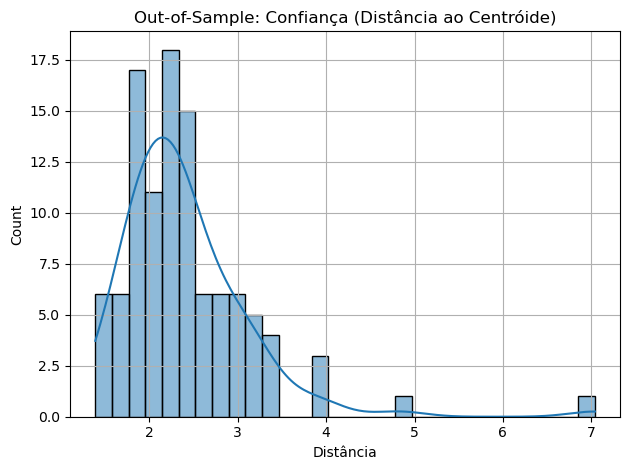

In [64]:
regime_classifier(df_ind)

In [34]:
df_ind#.dropna()

,id,symbol,timestamp,date,open,high,low,close,volume,trade_count,...,vix_norm,sp500,sp500_norm,market_return_1d,volatility,momentum,kurtosis,entropy,adf_pvalue,hurst
128,33552,AAPL,2022-07-11 04:00:00,2022-07-11,145.670,146.64,143.7800,144.87,69704810.0,496269.0,...,0.062094,38.5443,-0.011527,-0.011527,-0.221916,0.218670,-0.600715,1.114093,-0.541368,-0.085462
129,33553,AAPL,2022-07-12 04:00:00,2022-07-12,145.760,148.45,145.0500,145.86,84620032.0,579533.0,...,0.042797,38.1880,-0.009244,-0.009244,-0.206111,0.039087,-0.653589,0.781171,-0.153748,-0.059219
130,33554,AAPL,2022-07-13 04:00:00,2022-07-13,142.990,146.45,142.1201,145.49,77731553.0,559359.0,...,-0.017222,38.0178,-0.004457,-0.004457,-0.263474,-0.420489,-0.578768,0.378024,-0.142357,-0.042852
131,33555,AAPL,2022-07-14 04:00:00,2022-07-14,144.080,148.95,143.2500,148.47,83018114.0,614953.0,...,-0.015660,37.9038,-0.002999,-0.002999,-0.269627,-0.145533,-0.576416,0.378024,0.096372,-0.178093
132,33556,AAPL,2022-07-15 04:00:00,2022-07-15,149.780,150.86,148.2000,150.17,86944893.0,548571.0,...,-0.082197,38.6316,0.019201,0.019201,-0.242951,-0.011541,-0.562733,0.710946,-0.039175,-0.416650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,34276,AAPL,2025-05-29 04:00:00,2025-05-29,203.575,203.81,198.5100,199.95,51477938.0,652509.0,...,-0.006732,59.1217,0.004011,0.004011,-0.036202,-0.236449,-1.203109,1.114093,-1.559136,-0.306657
853,34277,AAPL,2025-05-30 04:00:00,2025-05-30,199.370,201.96,196.7800,200.85,70819942.0,605924.0,...,-0.031804,59.1169,-0.000081,-0.000081,-0.126750,0.250404,-1.160580,0.781171,-1.575147,-0.182465
854,34278,AAPL,2025-06-02 04:00:00,2025-06-02,200.280,202.13,200.1200,201.70,35423294.0,501431.0,...,-0.011309,59.3594,0.004102,0.004102,-0.177557,0.142495,-1.054064,0.781171,-1.489234,0.054384
855,34279,AAPL,2025-06-03 04:00:00,2025-06-03,201.350,203.77,200.9550,203.27,46381567.0,519820.0,...,-0.036492,59.7037,0.005800,0.005800,-0.321928,0.451547,-1.197646,0.781171,-1.477484,0.034453


In [106]:
import json
from sklearn.cluster import KMeans
from scipy.stats import f_oneway

# Refactored regime classifier to return metrics for logging
def regime_classifier(df_ind,
                      ticker,
                      features=["volatility", "momentum", "kurtosis", "entropy", "adf_pvalue", "hurst"], 
                      start_date="2023-01-01",
                      split_date="2024-01-01",
                      end_date="2024-06-01",
                      train_months=5,
                      test_months=5,
                      n_clusters=3,
                      seed=42,
                      scaler_class=StandardScaler,
                      verbose=False,
                      plot=False):

    df_clean = df_ind.dropna().copy()
    df_train = df_clean[(df_clean["date"] >= start_date) & (df_clean["date"] < split_date)].copy()
    df_test = df_clean[(df_clean["date"] >= split_date) & (df_clean["date"] <= end_date)].copy()

    if len(df_train) < 10 or len(df_test) < 10:
        return None  # Not enough data to evaluate

    # Scaling
    if scaler_class.__name__ == "QuantileTransformer":
        scaler = QuantileTransformer(output_distribution="normal")  # or "uniform"
    elif scaler_class.__name__ == "PowerTransformer":
        scaler = PowerTransformer(method="yeo-johnson")  # or "box-cox"
    else:
        scaler = scaler_class()
    
    X_train = scaler.fit_transform(df_train[features])
    X_test = scaler.transform(df_test[features])

    # Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
    df_train["regime"] = kmeans.fit_predict(X_train)
    df_test["regime"] = kmeans.predict(X_test)
    df_test["cluster_dist"] = kmeans.transform(X_test).min(axis=1)

    # ANOVA out-of-sample
    pvals = {}
    significant_count = 0
    for feat in features:
        groups = [df_test[df_test["regime"] == i][feat] for i in range(n_clusters) if (df_test["regime"] == i).shape[0] > 1]
        if len(groups) >= 2:
            _, pval = f_oneway(*groups)
            pvals[feat] = pval
            if pval < 0.05:
                significant_count += 1
        else:
            pvals[feat] = None

    result = {
        "ticker": ticker,
        "start_date": start_date,
        "split_date": split_date,
        "end_date": end_date,
        "n_clusters": n_clusters,
        "scaler_name": scaler_class.__name__,
        "train_size": len(df_train),
        "test_size": len(df_test),
        "train_months":train_months,
        "test_months":test_months,
        "regime_train_dist": json.dumps(df_train["regime"].value_counts().to_dict(),sort_keys=True),
        "regime_test_dist": json.dumps(df_test["regime"].value_counts().to_dict(),sort_keys=True),
        "anova_significant_features_test": significant_count
    }
    avg_pvals=[]
    # Add p-values
    for feat in features:
        result[f"pval_{feat}_test"] = pvals.get(feat)
        avg_pvals.append( pvals.get(feat))
    
    result[f"avg_pval_test"]= np.median(avg_pvals)
    # ANOVA in-sample
    pvals = {}
    significant_count = 0
    for feat in features:
        groups = [df_train[df_train["regime"] == i][feat] for i in range(n_clusters) if (df_train["regime"] == i).shape[0] > 1]
        if len(groups) >= 2:
            _, pval = f_oneway(*groups)
            pvals[feat] = pval
            if pval < 0.05:
                significant_count += 1
        else:
            pvals[feat] = None
    avg_pvals = []
    for feat in features:
        result[f"pval_{feat}_train"] = pvals.get(feat)
        avg_pvals.append( pvals.get(feat))
    
    result[f"avg_pval_train"]= np.median(avg_pvals)

    return result

In [107]:
import os
from dateutil.relativedelta import relativedelta
import ace_tools_open as tools
from sklearn.preprocessing import QuantileTransformer, PowerTransformer ,MaxAbsScaler,MinMaxScaler,StandardScaler,RobustScaler
results_path = f"data/experiments/{EXPERIENCE_NAME}.csv"

def discretize_result(result, thresholds={"anova_significant_features_test": [0, 2, 4, 6], "test_size": [0, 25, 50, 100]}):
    """
    Discretizes selected numerical results using thresholds.
    """
    discretized = {}

    # ANOVA strength category
    sig = result["anova_significant_features_test"]
    if sig < thresholds["anova_significant_features_test"][1]:
        discretized["anova_strength"] = "low"
    elif sig < thresholds["anova_significant_features_test"][2]:
        discretized["anova_strength"] = "medium"
    else:
        discretized["anova_strength"] = "high"

    # Test size category
    ts = result["test_size"]
    if ts < thresholds["test_size"][1]:
        discretized["test_size_cat"] = "tiny"
    elif ts < thresholds["test_size"][2]:
        discretized["test_size_cat"] = "small"
    elif ts < thresholds["test_size"][3]:
        discretized["test_size_cat"] = "medium"
    else:
        discretized["test_size_cat"] = "large"

    return {**result, **discretized}

def walkforward_refime_classifier(df,
                      tickers,
                      features=["volatility", "momentum", "kurtosis", "entropy", "adf_pvalue", "hurst"], 
                      start_date="2023-01-01",
                      train_months=5,
                      test_months=5,
                                  
                      n_clusters=3,
                      seed=42,
                      scalers=[QuantileTransformer, PowerTransformer ,MaxAbsScaler,MinMaxScaler,StandardScaler,RobustScaler],
                      verbose=False,
                      plot=False):

    for ticker in tickers:
        # Filter data for ticker
        df_ticker = df[df["symbol"] == ticker].copy()
        df_ticker = df_ticker.sort_values("date").reset_index(drop=True)

        # Define time range
        start = pd.to_datetime("2023-01-01")
        end = df_ticker["date"].max() - relativedelta(months=1)

        if os.path.exists(results_path):
            cached_results = pd.read_csv(results_path)
            cached_results["start_date"] = pd.to_datetime(cached_results["start_date"]).dt.date.astype(str)
            cached_results["split_date"] = pd.to_datetime(cached_results["split_date"]).dt.date.astype(str)
            cached_results["end_date"] = pd.to_datetime(cached_results["end_date"]).dt.date.astype(str)
            monthly_results = cached_results.to_dict("records")
        else:
            monthly_results = []


        # Loop through month-to-month windows
        while start < end:
            split = start + relativedelta(months=train_months)
            test_end = split + relativedelta(months=test_months)

            for scaler in scalers:
                config_id = f"{ticker}_{start.date()}_{split.date()}_{test_end.date()}_{n_clusters}_{scaler.__name__}"

                # Avoid recomputation if already processed
                if any(r["ticker"] == ticker and
                       r["start_date"] == str(start.date()) and
                       r["split_date"] == str(split.date()) and
                       r["end_date"] == str(test_end.date()) and
                       r["n_clusters"] == n_clusters and
                       r["scaler_name"] == scaler.__name__
                       for r in monthly_results):
                    continue

     
                result = regime_classifier(
                    df_ticker,
                    ticker,
                    features=["volatility", "momentum", "kurtosis", "entropy", "adf_pvalue", "hurst"], 
                    start_date=str(start.date()),
                    split_date=str(split.date()),
                    end_date=str(test_end.date()),
                    train_months=train_months,
                    test_months=test_months,
                    n_clusters=n_clusters,
                    scaler_class=scaler,
                     
                      seed=42
                    )
       

                if result:
                    result = discretize_result(result)
                    monthly_results.append(result)

            start += relativedelta(months=1)

        # Convert to DataFrame

        results_df = pd.DataFrame(monthly_results)
        results_df.to_csv(results_path, index=False)
        tools.display_dataframe_to_user(name="Regime Classification Results", dataframe=results_df)
        return results_df
results_df = walkforward_refime_classifier(df_ind,['AAPL'])

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (103). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (107). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (101). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  wa

Regime Classification Results


Loading ITables v2.4.0 from the internet... (need help?)


In [108]:
results_df[['scaler_name','avg_pval_train','avg_pval_test']].groupby("scaler_name").mean()

,avg_pval_train,avg_pval_test
scaler_name,,
MaxAbsScaler,0.004726,0.004712
MinMaxScaler,0.001128,0.003301
PowerTransformer,0.000002,0.001076
QuantileTransformer,0.000020,0.007835
RobustScaler,0.000018,0.003185
StandardScaler,0.000083,0.004865
